In [1]:
from PIL import Image
import numpy as np
import scipy.misc as misc
import pandas as pd
import re
import scipy
import matplotlib.pyplot as plt
import os
import json
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

import scipy.io
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
import time
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

import imp 
util = imp.load_source('f_plot_obj', 'fotranPlot/fPlotFuntion.py') 
import f_plot_obj

print(scipy.__version__)


1.1.0


In [18]:
def prepare_dataset(dir_path, seq):
        df =[]
        with open(os.path.join(dir_path, seq, 'material.JSON')) as f:
            data = json.loads(f.read())['20*20']
        data = np.array(data).reshape([20,20]) 
        label= []
        for r_index, row in enumerate(data):
            for e_index, e in enumerate(row):
                label.append((e, r_index, e_index, seq))        
        ims = []
        for n_index, i in enumerate(num):
            filepath = os.path.join(dir_path, seq, i)        
            with open(filepath) as f:
                data = json.loads(f.read())['21*21']
            data = np.array(data).reshape([21,21])            
            for r_index, row in enumerate(data):
                for e_index, e in enumerate(row):
                    ims.append((e, r_index, e_index, n_index, seq))

        for y in range(20):
            for x in range(20): 
                same_wp = []
                same_wp.append(y)
                same_wp.append(x)
                for row in ims:
                    if row[1]==y and row[2]==x:
                        same_wp.append(row[0])
                    if row[1]==y+1 and row[2]==x:
                        same_wp.append(row[0])
                    if row[1]==y and row[2]==x+1:
                        same_wp.append(row[0])
                    if row[1]==y+1 and row[2]==x+1:
                        same_wp.append(row[0])
                for row in label:
                    if row[1]==y and row[2]==x:
                        same_wp.append(row[0])
                df.append(same_wp)
        df = pd.DataFrame(df)
        return df[df.columns[0:82]], df[df.columns[82]]

In [19]:
dir_path = r'/home/cuda/benchuang/TONG_well_inverse'

_start = 1
_seqs = 1001
_num = 21

RNG=1000

validation_seq=9002


# Training image data preprocessing

In [20]:

# filename, example F0000001, F0000002
seqs = range(_start,_seqs)
seqs = ['F'+str(i).zfill(7) for i in seqs]

num = range(1,_num)
num = ['Stress'+str(i).zfill(2)+'.JSON' for i in num]

# preprocess start time
start = time.time()

# image extraction
if os.path.exists('TONG_{0}_training.pickle'.format(_seqs-1)):
    dataframe=pd.read_pickle('TONG_{0}_training.pickle'.format(_seqs-1))
    print(np.shape(dataframe))
else:
    dataframe = []
    for s_index, seq in enumerate(seqs):
            print(seq)
            with open(os.path.join(dir_path, seq, 'material.JSON')) as f:
                data = json.loads(f.read())['20*20']
            data = np.array(data).reshape([20,20]) 
            
            # label image
            label= []
            for r_index, row in enumerate(data):
                for e_index, e in enumerate(row):
                # Label image introduction
                # e: value. (float)
                # r_index: y axis index. (1-21)
                # e_index: x axis index. (1-21)
                # s_index: page number (1-20)
                    label.append((e, r_index, e_index, s_index))        
            
            # feature image 
            ims = []
            for n_index, i in enumerate(num):
                filepath = os.path.join(dir_path, seq, i)        
                with open(filepath) as f:
                    data = json.loads(f.read())['21*21']
                data = np.array(data).reshape([21,21])
                # Feature image introduction
                # e: value. (float)
                # r_index: y axis index. (1-21)
                # e_index: x axis index. (1-21)
                # s_index: page number (1-20)
                for r_index, row in enumerate(data):
                    for e_index, e in enumerate(row):
                        ims.append((e, r_index, e_index, n_index, s_index))
                        
            # feature extraction from feautre image
            for y in range(20):
                for x in range(20): 
                    same_wp = []
                    same_wp.append(y) # col 0
                    same_wp.append(x) # col 1
                    for row in ims:
                        if row[1]==y and row[2]==x: # col 2, 6, .. 78
                            same_wp.append(row[0])
                        if row[1]==y+1 and row[2]==x: # col 3, 7, .. 79
                            same_wp.append(row[0])
                        if row[1]==y and row[2]==x+1: # col 4, 8, .. 80
                            same_wp.append(row[0])
                        if row[1]==y+1 and row[2]==x+1: # col 5, 9, .. 81
                            same_wp.append(row[0])
                    for row in label:
                        if row[1]==y and row[2]==x:
                            same_wp.append(row[0]) # 82
                    dataframe.append(same_wp)
                    
    # dataframe, the shape of feature and label 
    print(np.shape(dataframe))
    dataframe = pd.DataFrame(dataframe)

    # save the pickle if not exist
    if not os.path.exists('TONG_{0}_training.pickle'.format(_seqs-1)):
        dataframe.to_pickle('TONG_{0}_training.pickle'.format(_seqs-1))

# preprocess end time
end = time.time()
loading_elapsed = end - start

print('loading elapsed time: {0} seconds'.format(loading_elapsed))

# get the specific dataset account
dataframe = dataframe[0:(400*RNG)]
print(np.shape(dataframe))
_seqs = RNG+1


(400000, 83)
loading elapsed time: 2.43927264213562 seconds
(400000, 83)


In [21]:
# print(dataframe[[0,1,6,8,11,15,19,20,67,71,79,80]])

# page = range(1,21)
# feature_list = []
# feature_list.append('x')
# feature_list.append('y')
# for i in page:
#     feature_list.append('page{0}_cnr{1}'.format(i, 'LT'))
#     feature_list.append('page{0}_cnr{1}'.format(i, 'LB'))
#     feature_list.append('page{0}_cnr{1}'.format(i, 'RT'))
#     feature_list.append('page{0}_cnr{1}'.format(i, 'RB'))
    
# # print(feature_list)
# for id, i in enumerate(feature_list):
#     print(id, i)

# [Randmo Forest] Train and Save model & Evaluation Random Forest models

In [23]:
# Training start time
start = time.time()

ne = 50

# split datasets to training and validation parts.
X_train, X_test, y_train, y_test = train_test_split(dataframe[[0,1,6,8,11,15,19,20,67,71,79,80]], dataframe[dataframe.columns[82]], train_size=0.8, random_state=42)

# rf_(traingsize)_(page)_(n_estimators)
model_name = 'rf_{0}_{1}_{2}_fs'.format(_seqs-_start,_num-1,ne)

if os.path.exists(model_name):
    print('load model {}...'.format(model_name))
    rf = joblib.load(model_name)
else:
    rf = RandomForestRegressor(n_estimators=ne, oob_score=True, random_state=0)
    rf.fit(X_train, y_train)

# evaluation models
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)

# Training end time
end = time.time()
elapsed = end - start

print('predict spends {} seconds'.format(elapsed))
print('predict parameters:')
print(rf.score)

if not os.path.exists(model_name):
    joblib.dump(rf, model_name)

#读取Model
# clf3 = joblib.load('save/clf.pkl')
#测试读取后的Model
# print(clf3.predict(X[0:1]))
# [0]

print('datasets: {0}, n_estimators: {1},training spend {2} seconds'.format(_seqs-1, rf.n_estimators, elapsed))
print('\toob_score: {0}'.format(rf.oob_score_))
print('\tr2_score: {0}'.format(test_score))
print('\tspearman: {0}'.format(spearman))
print('\tpearson: {0}'.format(pearson))



predict spends 254.54932355880737 seconds
predict parameters:
<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)>
datasets: 1000, n_estimators: 50,training spend 254.54932355880737 seconds
	oob_score: 0.5901025772337897
	r2_score: 0.5984841075181593
	spearman: SpearmanrResult(correlation=0.8272862155455085, pvalue=0.0)
	pearson: (0.7740276303584435, 0.0)


# Prediction Random Forest  

In [28]:

num = range(1,_num)
num = ['Stress'+str(i).zfill(2)+'.JSON' for i in num]
seq = 'F'+str(validation_seq).zfill(7)
print('Valid dataset {}'.format(seq))

# Predict start time
start = time.time()

val_X, val_y = prepare_dataset(dir_path, seq)
val_X = val_X[[0,1,6,8,11,15,19,20,67,71,79,80]]
predicted_dataset = rf.predict(val_X)

# Predict end time
end = time.time()
elapsed = end - start
print('Predict data spends {} seconds'.format(elapsed))

test_score = r2_score(val_y, predicted_dataset)
spearman = spearmanr(val_y, predicted_dataset)
pearson = pearsonr(val_y, predicted_dataset)
print('r2_score: {0}'.format(test_score))
print('spearman: {0}'.format(spearman))
print('pearson: {0}'.format(pearson))

# Calculate the absolute errors
errors = abs(predicted_dataset - val_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / val_y)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Reshape array to 2-d
image = np.array(predicted_dataset).reshape([20,20])
val_image = np.array(val_y).reshape([20,20])

# # Move to directory 
# dataset_name='F{}'.format(str(validation_seq).zfill(7))
# DIR_NAME = 'Stress_plot_{0}'.format(dataset_name)
# if not os.path.exists(DIR_NAME):
#     os.mkdir(DIR_NAME)

# # output predict .dat 
# f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=predicted_dataset, format=1, x=21, y=21)
# file = [item for item in os.listdir() if 'RES' in item][0]
# os.rename(file, 'rf_{}_predict_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7)))

# # output val_image .dat
# f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=val_y, format=1, x=21, y=21)
# file = [item for item in os.listdir() if 'RES' in item][0]
# os.rename(file, 'rf_{}_val_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7)))

# # output predict and val raw data
# with open(os.path.join(DIR_NAME ,'rf_{}_F{}.txt'.format(_seqs-1, str(validation_seq).zfill(7))),'w') as f:
#     f.write(' '.join(val_y.astype(str))+'\n')
#     f.write(' '.join(predicted_dataset.astype(str))+'\n')
# print('Raw data write finish!')

# # output difference data
# diff_list = predicted_dataset-val_y
# with open(os.path.join(DIR_NAME ,'rf_{}_diff_F{}.txt'.format(_seqs-1, str(validation_seq).zfill(7))),'w') as f:
#     f.write(' '.join(diff_list.astype(str))+'\n')
# print('Diff write finish!')

# pred_file='rf_{}_predict_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7))
# val_file='rf_{}_val_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7))                                         
# shutil.move(pred_file, os.path.join(DIR_NAME, pred_file))
# shutil.move(val_file, os.path.join(DIR_NAME, val_file))
    

Valid dataset F0009002
Predict data spends 1.097377061843872 seconds
r2_score: 0.47890406141304487
spearman: SpearmanrResult(correlation=0.7096709293738572, pvalue=1.63837107917329e-62)
pearson: (0.7021019644114626, 1.1476383052590726e-60)
Mean Absolute Error: 2.38 degrees.
Accuracy: 16.03 %.


In [7]:
def predict(validation_seq):
    num = range(1,_num)
    num = ['Stress'+str(i).zfill(2)+'.JSON' for i in num]
    seq = 'F'+str(validation_seq).zfill(7)
    print('Valid dataset {}'.format(seq))

    # Predict start time
    start = time.time()

    val_X, val_y = prepare_dataset(dir_path, seq)
    predicted_dataset = rf.predict(val_X)

    # Predict end time
    end = time.time()
    elapsed = end - start
    print('Predict data spends {} seconds'.format(elapsed))

    test_score = r2_score(val_y, predicted_dataset)
    spearman = spearmanr(val_y, predicted_dataset)
    pearson = pearsonr(val_y, predicted_dataset)
    print('r2_score: {0}'.format(test_score))
    print('spearman: {0}'.format(spearman))
    print('pearson: {0}'.format(pearson))

    # Calculate the absolute errors
    errors = abs(predicted_dataset - val_y)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / val_y)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    # Reshape array to 2-d
    image = np.array(predicted_dataset).reshape([20,20])
    val_image = np.array(val_y).reshape([20,20])

    # Move to directory 
    dataset_name='F{}'.format(str(validation_seq).zfill(7))
    DIR_NAME = 'Stress_plot_{0}'.format(dataset_name)
    if not os.path.exists(DIR_NAME):
        os.mkdir(DIR_NAME)

    # output predict .dat 
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=predicted_dataset, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'rf_{}_predict_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7)))

    # output val_image .dat
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=val_y, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'rf_{}_val_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7)))

    # output predict and val raw data
    with open(os.path.join(DIR_NAME ,'rf_{}_F{}.txt'.format(_seqs-1, str(validation_seq).zfill(7))),'w') as f:
        f.write(' '.join(val_y.astype(str))+'\n')
        f.write(' '.join(predicted_dataset.astype(str))+'\n')
    print('Raw data write finish!')

    # output difference data
    diff_list = predicted_dataset-val_y
    with open(os.path.join(DIR_NAME ,'rf_{}_diff_F{}.txt'.format(_seqs-1, str(validation_seq).zfill(7))),'w') as f:
        f.write(' '.join(diff_list.astype(str))+'\n')
    print('Diff write finish!')

    pred_file='rf_{}_predict_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7))
    val_file='rf_{}_val_F{}.dat'.format(_seqs-1, str(validation_seq).zfill(7))                                         
    shutil.move(pred_file, os.path.join(DIR_NAME, pred_file))
    shutil.move(val_file, os.path.join(DIR_NAME, val_file))


    
for vs in range(9001,9021):
    predict(vs)
    print()
    
    

Valid dataset F0009001
Predict data spends 2.624998092651367 seconds
r2_score: 0.46897887971207697
spearman: SpearmanrResult(correlation=0.7626196754438554, pvalue=2.6163951419037796e-77)
pearson: (0.713187203712867, 2.17142735050203e-63)
Mean Absolute Error: 2.41 degrees.
Accuracy: 1.41 %.
Raw data write finish!
Diff write finish!

Valid dataset F0009002
Predict data spends 1.0403363704681396 seconds
r2_score: 0.5447256540590772
spearman: SpearmanrResult(correlation=0.7644116586913543, pvalue=7.073239847847629e-78)
pearson: (0.7383645057622039, 4.387506007970155e-70)
Mean Absolute Error: 2.16 degrees.
Accuracy: 25.08 %.
Raw data write finish!
Diff write finish!

Valid dataset F0009003
Predict data spends 1.042635202407837 seconds
r2_score: 0.5458353847194526
spearman: SpearmanrResult(correlation=0.7793022256774018, pvalue=8.410232166697104e-83)
pearson: (0.7456642001872442, 3.585845861705572e-72)
Mean Absolute Error: 2.52 degrees.
Accuracy: 26.89 %.
Raw data write finish!
Diff write f

# PLOT Predict and Validation

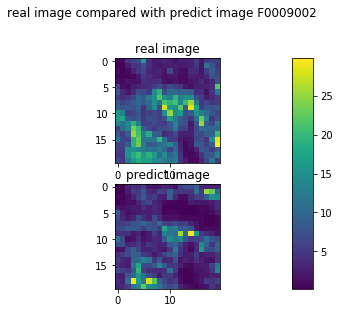

In [29]:
# plot original label image
plt.subplot(211)
plt.title('real image')
plt.imshow(image)

# plot predict image
plt.subplot(212)
plt.title('predict image')
plt.imshow(val_image)

# adjust plot location
plt.subplots_adjust(bottom=0, right=0.9, top=0.8)
cax = plt.axes([0.8, 0.0, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.suptitle('real image compared with predict image {0}'.format(seq), fontsize=12)
plt.show()

# Analysis the Random Forest models 

Variable: page20_cnrRT         Importance: 0.15
Variable: page2_cnrLT          Importance: 0.11
Variable: page2_cnrRT          Importance: 0.11
Variable: page5_cnrRT          Importance: 0.11
Variable: page20_cnrLB         Importance: 0.1
Variable: x                    Importance: 0.07
Variable: page3_cnrLB          Importance: 0.07
Variable: page5_cnrLB          Importance: 0.07
Variable: page17_cnrLB         Importance: 0.07
Variable: page18_cnrLB         Importance: 0.06
Variable: page4_cnrLB          Importance: 0.05
Variable: y                    Importance: 0.04


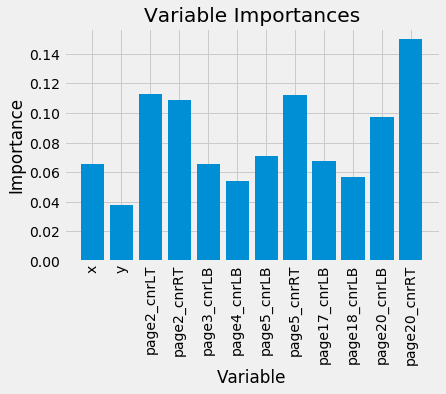

In [31]:
page = range(1,21)
feature_list = ['x','y','page2_cnrLT','page2_cnrRT','page3_cnrLB','page4_cnrLB','page5_cnrLB','page5_cnrRT','page17_cnrLB','page18_cnrLB','page20_cnrLB','page20_cnrRT']
# feature_list.append('x')
# feature_list.append('y')
# for i in page:
#     feature_list.append('page{0}_cnr{1}'.format(i, 'LT'))
#     feature_list.append('page{0}_cnr{1}'.format(i, 'LB'))
#     feature_list.append('page{0}_cnr{1}'.format(i, 'RT'))
#     feature_list.append('page{0}_cnr{1}'.format(i, 'RB'))

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');